In [1]:
from spineq.optimise import calc_oa_weights, optimise
from spineq.plotting import plot_oa_importance, plot_oa_weights, plot_optimisation_result

import os
from pathlib import Path
import pandas as pd
import numpy as np
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

In [2]:
# fivethirtyeight style defaults but with white background
plt.style.use("fivethirtyeight")
mpl.rcParams['figure.facecolor'] = "white"
mpl.rcParams['savefig.facecolor']= "white"

save_dir = "paper_figures"
os.makedirs(save_dir, exist_ok=True)

In [3]:
population_groups = {
    "pop_total": {"min": 0, "max": 90, "weight": 1, "title": "Total Population"},
    "pop_children": {"min": 0, 'max': 16, "weight": 1, "title": "Children"},
    "pop_elderly": {"min": 70, "max": 90, "weight": 1, "title": "Elderly"},
}

all_groups = dict(population_groups)
all_groups["workplace"] = {"title": "Workplace"}

In [4]:
def get_fig_grid(figsize=(15, 15), nrows_ncols=(2, 2)):
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(
        fig, 111,
        nrows_ncols=nrows_ncols,
        axes_pad=0.35,
        share_all=True,
        cbar_location="right",
        cbar_mode="single",
        cbar_size="4%",
        cbar_pad=0.35,
    )
    
    return fig, grid


def add_colorbar(ax, vmin=0, vmax=1, cmap="plasma", label=""):
    ax.cax.colorbar(
        mpl.cm.ScalarMappable(
            norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax),
            cmap=cmap
        ),
        label=label
    )

    
def save_fig(
    fig, filename, save_dir=save_dir, dpi=300, bbox_inches="tight"
):
    fig.savefig(
        Path(save_dir, filename),
        dpi=dpi, bbox_inches=bbox_inches
    )


In the meantime, if you have chance, it would be useful to have some high-resolution version of the maps you have produced (300 dpi minimum), with a single legend / scale, so that they could be included in the paper:

- Figure mapping distribution of all demographic variables included in analysis (total population, children, older persons, place of work
- Figure for each demographic variable showing coverage based on 10 and 50 (?) sensor solutions for 100 and 500 theta solutions (4 maps in total on one figure) (is the number 50 a good choice)
- Figure showing maps for a selection of variables using the same number of sensors/theta value.
- Figure showing comparison with existing network of air quality sensors. 


## Distribution of Demographic Variables

In [5]:
oa_weights = {}

for name, weights in population_groups.items():
    oa_weights[name] = calc_oa_weights(
        pop_age_groups={name: weights},
        population_weight=1,
        workplace_weight=0
    )

oa_weights["workplace"] = calc_oa_weights(
    population_weight=0,
    workplace_weight=1
)


In [6]:
for i, g in enumerate(all_groups.items()):
    print(i, g[0], g[1])

0 pop_total {'min': 0, 'max': 90, 'weight': 1, 'title': 'Total Population'}
1 pop_children {'min': 0, 'max': 16, 'weight': 1, 'title': 'Children'}
2 pop_elderly {'min': 70, 'max': 90, 'weight': 1, 'title': 'Elderly'}
3 workplace {'title': 'Workplace'}


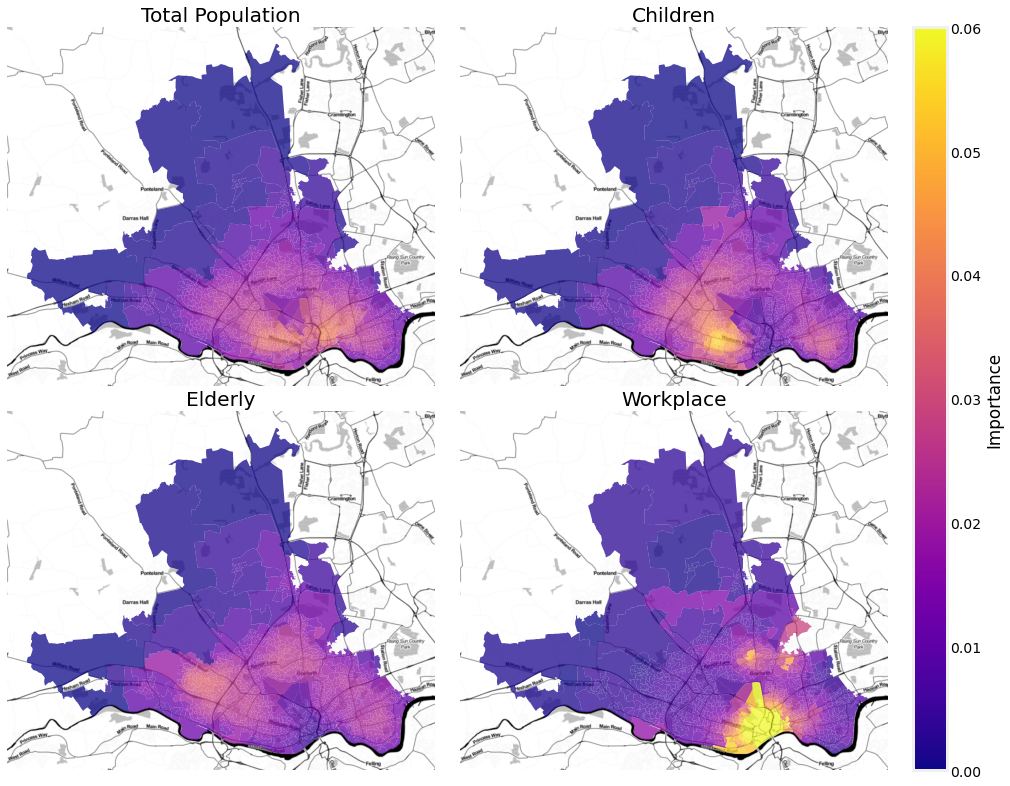

In [7]:
theta = 500
vmax = 0.06

fig, grid = get_fig_grid()

for i, g in enumerate(all_groups.items()):
    name = g[0]
    title = g[1]["title"]
    plot_oa_importance(
        oa_weights[name], theta=theta, vmax=vmax, ax=grid[i],
        show=False, legend=False, title=title
    )

add_colorbar(grid[-1], vmax=vmax, label="Importance")
save_fig(fig, "demographics_importance.png")

---

Including deprivation somehow in the discussion of the analysis. Unfortunately there aren't any suitable datasets at the Output Area (OA) scale that was used for the other demographic variables. But as an alternative, we thought it might be useful to do a simple analysis / overlay, that takes the sensor networks derived from the spatial optimisation and assesses how well they would cover the city in terms of deprivation i.e. we would apply the network that was derived from the spatial distribution of OA-scale older persons variable to the LSOA-scale deprivation variable, and see what types of areas are "covered" in terms of deprivation. Do you think this would be useful? If so, that could be good  - or alternatively, I can generate this if you output the sensor networks from the optimisation as shapefiles?

---

Perhaps instead of deprivation we could use the genetic algorithm results with children x elderly x work population? That illustrated the trade-offs really well.
 
If we then showed a map of sensors and deprivation (IMD) in, eg, discussion, we could show how other factors are also likely to be important, even if we don't directly address them in the paper?
 
For the analysis, this could be something like:
 
- first cut of sensor location based on total population
 
- initial solo variable illustrations that show how coverage varies as number of sensors increases (similar to what we have now)
 
- analysis with combination of three variables that shows 1) how few solutions provide minimal coverage of all three variables and 2) how decisionmakers could operationalise trade-offs, which are very apparent in the results
 
Then discussion (or end of analysis section) could:
 
- compare part 1 of analysis to Urban Observatory locations, just as an illustration of differences
 
- compare part 1 (and part 3?) to a map of IMD in Newcastle
 

In [8]:
from spineq.data_fetcher import get_oa_shapes, get_oa_stats

oa = get_oa_shapes()
oa["area"] = oa["geometry"].area / 1e6  # km^2

stats = get_oa_stats()
for name, config in population_groups.items():
    group_pop = stats["population_ages"].loc[
        :,
        (stats["population_ages"].columns >= config["min"])
        & (stats["population_ages"].columns <= config["max"]),
    ].sum(axis=1)
    group_pop.name = name
    oa = oa.join(group_pop)

workplace = stats["workplace"]
workplace.name = "workplace"
oa = oa.join(workplace)

for group in all_groups.keys():
    oa[f"{group}_perc"] = oa[group] / oa[group].sum()
    oa[f"{group}_reld"] = oa[f"{group}_perc"] / oa["area"]


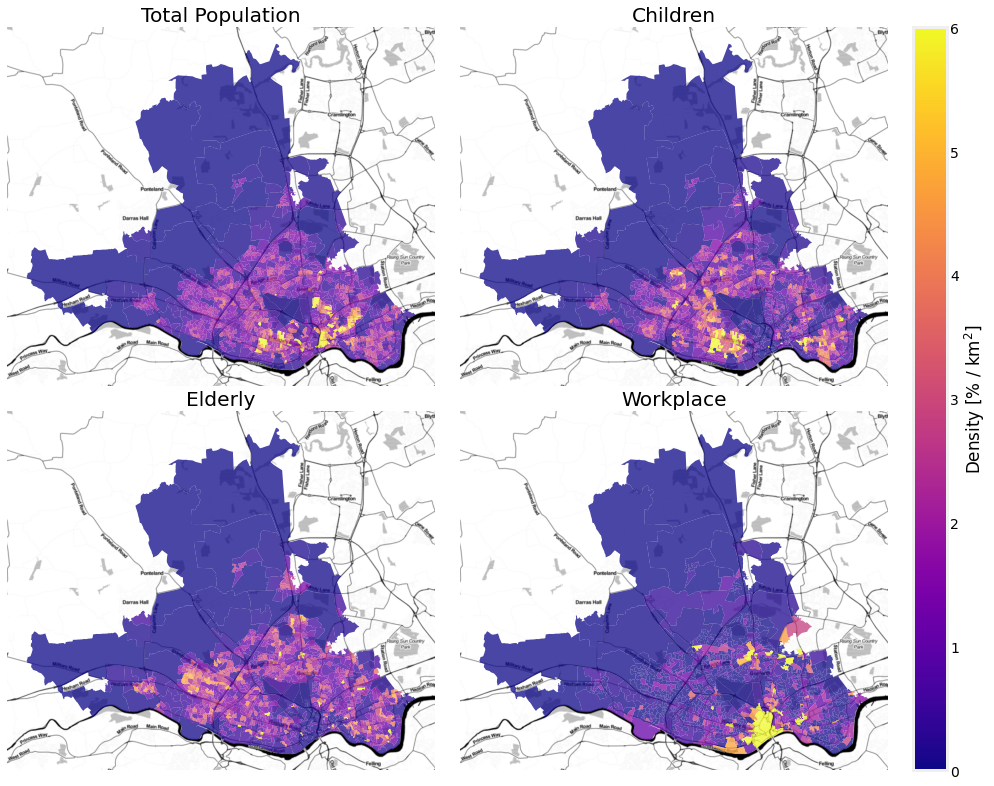

In [9]:
vmax = 6
fig, grid = get_fig_grid()

for i, g in enumerate(all_groups.items()):
    name = g[0]
    title = g[1]["title"]
    plot_oa_weights(
        100 * oa[f"{name}_reld"],
        title=title,
        vmax=vmax,
        ax=grid[i],
        legend=False,
        show=False,
    )

add_colorbar(
    grid[-1], vmax=vmax,
    label="Density [% / $\mathrm{km}^2$]"
)
save_fig(fig, "demographics_density.png")

## Single-Variable Networks


In [10]:
thetas = [100, 250, 500]
n_sensors = [10, 20, 50, 60]

In [11]:
regen_networks = False
networks_path = Path(save_dir, "networks_singleobj.pkl")

if regen_networks:
    results = {}

    for name, weights in population_groups.items():
        results[name] = {}

        for theta in thetas:
            results[name][f"theta{theta}"] = {}

            for n in n_sensors:
                print("=" * 20)
                print(name, ", theta", theta, ", n_sensors", n)
                print("=" * 20)
                result = optimise(
                    n_sensors=n,
                    theta=theta,
                    population_weight=1,
                    workplace_weight=0,
                    pop_age_groups={name: weights}
                )
                results[name][f"theta{theta}"][f"{n}sensors"] = result

    name = "workplace"
    results[name] = {}
    for theta in thetas:
        results[name][f"theta{theta}"] = {}

        for n in n_sensors:
            print("=" * 20)
            print(name, ", theta", theta, ", n_sensors", n)
            print("=" * 20)
            result = optimise(
                n_sensors=n,
                theta=theta,
                population_weight=0,
                workplace_weight=1,
            )
            results[name][f"theta{theta}"][f"{n}sensors"] = result

    with open(networks_path, "wb") as f:
        pickle.dump(results, f)
        
else:
    with open(networks_path, "rb") as f:
        results = pickle.load(f)

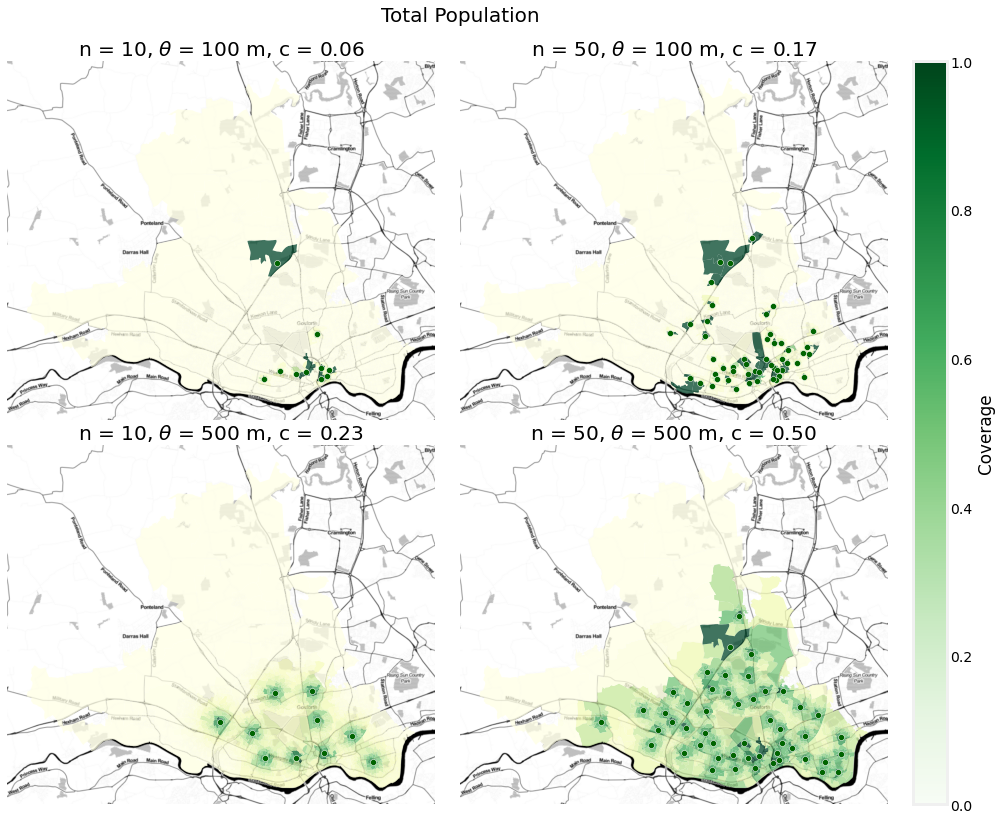

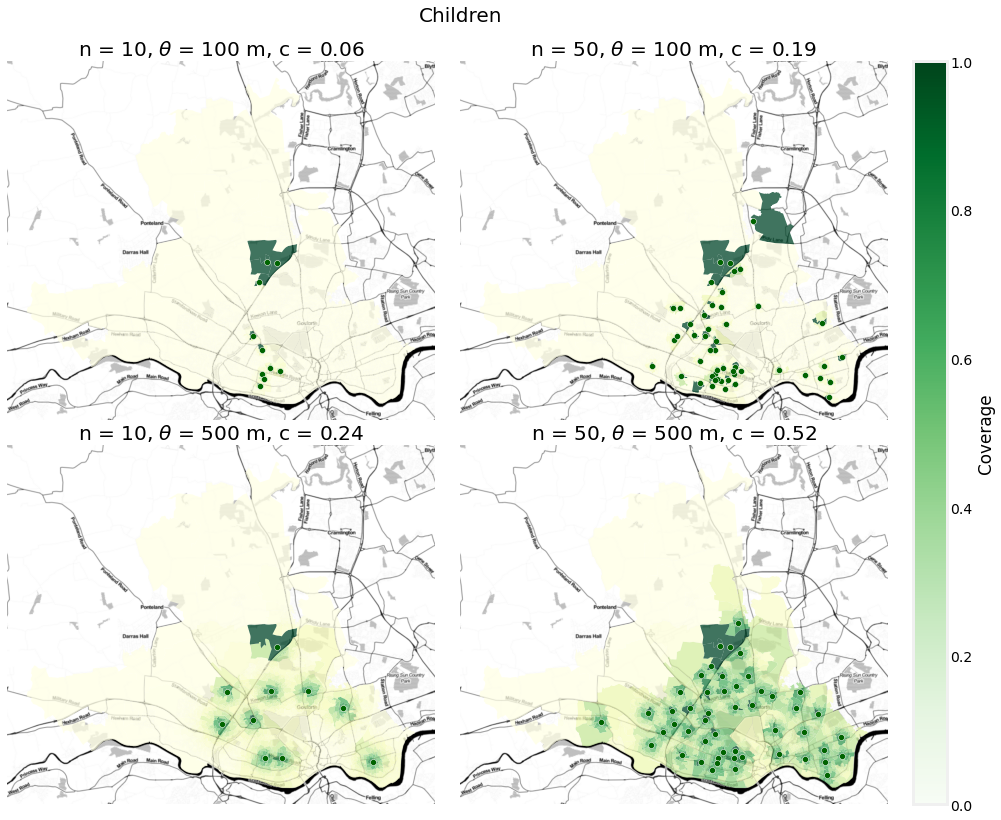

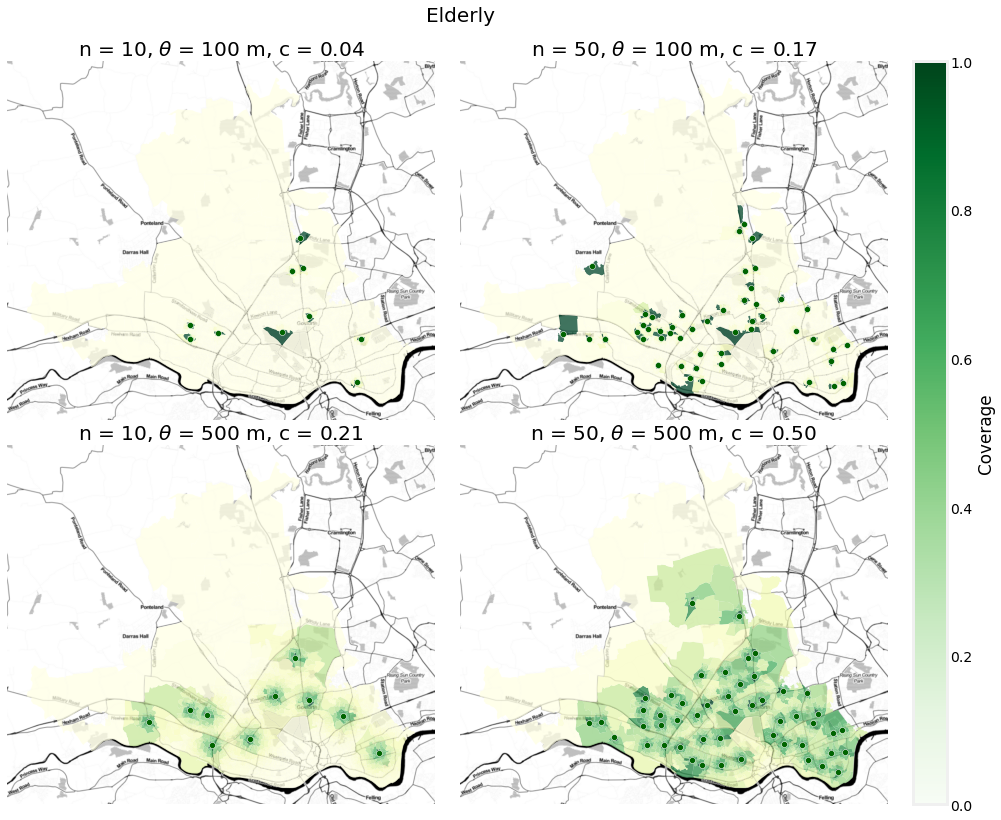

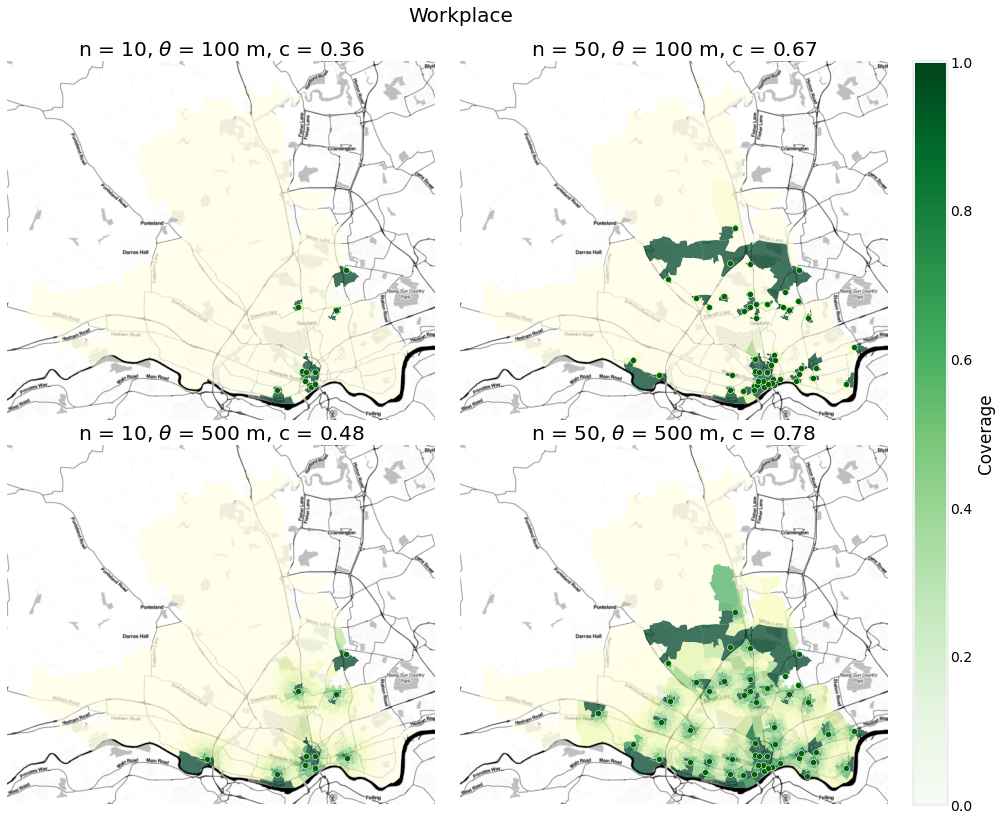

In [50]:
plot_thetas = [100, 500]
plot_sensors = [10, 50]

for plot_obj in all_groups.keys():
    fig, grid = get_fig_grid()
    i = 0
    for t in plot_thetas:
        for s in plot_sensors:
            r = results[plot_obj][f"theta{t}"][f"{s}sensors"]
            plot_optimisation_result(
                r,
                title=f"n = {s}, $\\theta$ = {t} m, c = {r['total_coverage']:.2f}",
                ax=grid[i], show=False, legend=False
            )
            i += 1

    add_colorbar(
        grid[-1],
        label="Coverage",
        cmap="Greens"
    )

    fig.suptitle(all_groups[plot_obj]["title"], y=0.87, fontsize=20)

Text(410500, 577800, '1 km')

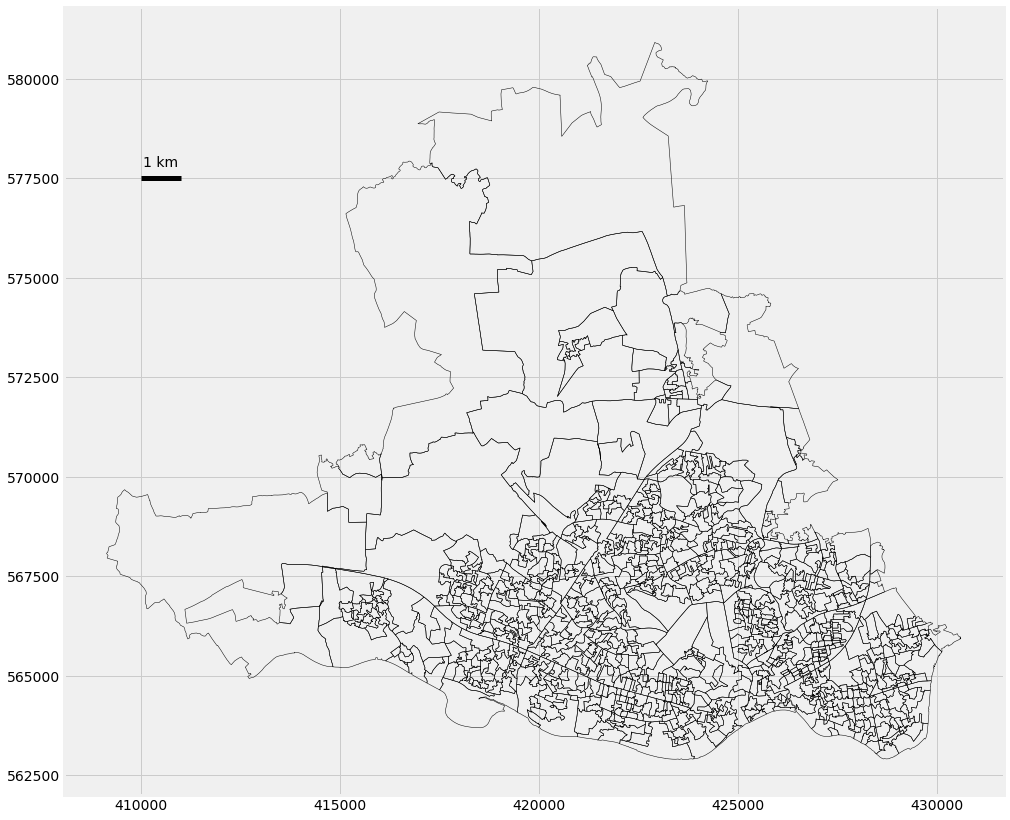

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
oa.plot(ax=ax, color="None", edgecolor="k")
ax.plot([410000, 411000], [577500, 577500], linewidth=5, color="k")
ax.annotate("1 km", (410500, 577800), ha="center")